In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import random


In [3]:
baskets = pd.read_parquet("baskets.parquet")
coupons = pd.read_parquet("coupons.parquet")
prediction_index = pd.read_parquet("prediction_index.parquet")

In [5]:
random.seed(123)
sample_idx = random.sample(range(99999), 10000)
sample_b = baskets[baskets["shopper"].isin(sample_idx)]

## EDA

In [6]:
print(f"There are {len(np.unique(baskets.shopper))} unique shoppers.")
print(f"There are {len(np.unique(baskets.product))} unique products.")
print(f"There are {len(np.unique(baskets.week))} weeks.")


There are 100000 unique shoppers.
There are 1 unique products.
There are 90 weeks.


Apparently all first purchases happened within the first week. Thus, we have for every customer enough training data.

In [7]:
#lowest amount of data we have for a customer, latest week customer joined
max_ = np.max(baskets.groupby('shopper').min('week').week)
min_ = np.min(baskets.groupby("shopper").product.count())
print(f"The maximum number of first week of a customer is {max_}.")
print(f"Lowest amount of purchases is {min_}.")

The maximum number of first week of a customer is 1.
Lowest amount of purchases is 289.


### Price

In [23]:
baskets[(baskets['product'] == 71) & (baskets['price'] < 629)]

,week,shopper,product,price
2325,0,310,71,534
9305,0,1219,71,377
12945,0,1706,71,471
21009,0,2752,71,566
22202,0,2910,71,440
...,...,...,...,...
68819732,89,97145,71,377
68823709,89,97660,71,377
68825246,89,97861,71,408
68832662,89,98821,71,377


In [25]:
baskets[(baskets['product'] == 71) & (baskets['shopper'] == 12)]

,week,shopper,product,price
3058623,4,12,71,629
13007222,17,12,71,629
17596881,23,12,71,629
21421205,28,12,71,629
45895445,60,12,71,629


In [27]:
coupons[(coupons['product'] == 71) & (coupons.shopper == 12)]

,week,shopper,product,discount
64,0,12,71,10
7500063,15,12,71,35
38500063,77,12,71,25


In [28]:
np.unique(baskets['product'])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### Purchased Products

In [8]:
unique_products_per_shopper = baskets.groupby("shopper").product.apply(lambda x: len(np.unique(x)))
products_per_shopper = baskets.groupby("shopper").product.count()

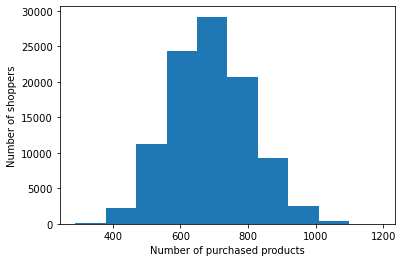

In [9]:
#wenig aussagekräftig
plt.hist(products_per_shopper);
plt.xlabel("Number of purchased products")
plt.ylabel("Number of shoppers");

In [10]:
# in how many weeks did a shopper buy something?
g = sample_b.groupby(["shopper", "week"]).product.count()
# approach did not work, but they most likely bought something in nearly every week

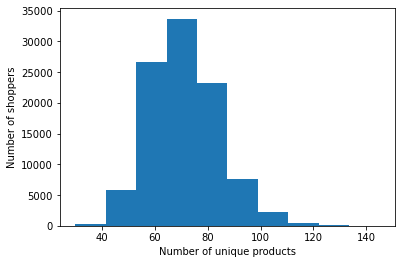

In [11]:
#wieviele verschiedene produkte werden gekauft
#wichtiger: wieviele verschiede produkte werden gekauft in relation zu den insgesamt gekauften produkten
#sample_b.groupby("shopper").product.apply(lambda x: list(np.unique(x)))
plt.hist(unique_products_per_shopper)
plt.xlabel("Number of unique products")
plt.ylabel("Number of shoppers");

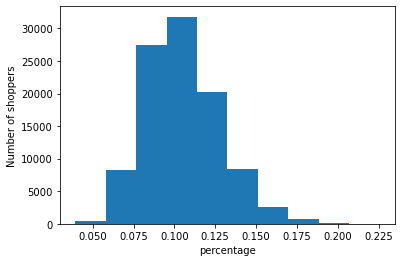

In [12]:
plt.hist(unique_products_per_shopper / products_per_shopper)
plt.xlabel("percentage")
plt.ylabel("Number of shoppers");

### Related to target

In [16]:
#Does a high discount relate to higher chance of buying the next time?
coupons

,week,shopper,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
...,...,...,...,...
44999995,89,99999,62,40
44999996,89,99999,110,10
44999997,89,99999,37,40
44999998,89,99999,155,25


In [20]:
baskets[baskets.week == 0  baskets.shopper == 0]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Baseline

In [30]:
prediction_index

,week,shopper,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4
...,...,...,...
499995,90,1999,245
499996,90,1999,246
499997,90,1999,247
499998,90,1999,248


In [32]:
train = baskets[baskets.week < 88]
test = baskets[baskets.week == 89]

MemoryError: Unable to allocate 2.01 GiB for an array with shape (4, 67311927) and data type int64

In [31]:
0:89

SyntaxError: illegal target for annotation (<ipython-input-31-f2cdcfa98abf>, line 1)

## From Lecture (relevant for exam)


* we assume the products belong to categories, but categories are unknown
* we assume we buy one product out of a category
* categories are related (complements and subtitutes
    * e.g. cola vs mate 



* binary classification for each product is a bad idea
* assumption: one product out of each catgory is purchaed if the category is purchased
    * category as binary and within the category multinomial
    * softmax ? 
    


* products are bought in intervals
* discounts have different effects depending on the current probability of buying a product
* promotion for substitute decreases probability

* we have to look out for cases:
    * case 1: straight line: probability is always the same
    * case 2: straight line with peak down, because you bought product but a day later you want new
    * case 3: probability going up.

* how to model interdependencies between product or categories?
* C multinomial!

Features:
* Stockpiling? What is that
* price (and sensitivity): do changes in prices lead to changes in probability

Ideas for features:
* binary product purchase events (as vector)
* timessince last product purchase
* product purchase fequencies
* coupon redemption rate